## Packages & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
# https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset
df = pd.read_csv("online_shoppers_intention.csv")
rate_by_ads = df.groupby('Region')['Revenue'].mean().tolist()

## Random Agent

In [2]:
class Bandit:
    def __init__(self, arm_count, true_rewards):
        self.arm_count = arm_count
        self.true_rewards = true_rewards
        self.arm_counts = np.zeros(arm_count)
    
    def get_reward(self, arm):
        return self.true_rewards[arm]
    

def random_algorithm(bandit, iterations):
    arm_count = bandit.arm_count
    rewards = []
    regret = 0
    regrets = []
    
    for _ in range(iterations):
        arm = np.random.choice(arm_count)  # Randomly select an arm
        reward = bandit.get_reward(arm)
        rewards.append(reward)
        regret += max(bandit.true_rewards) - bandit.true_rewards[arm]
        regrets.append(regret)
        bandit.arm_counts[arm] += 1
    
    return rewards, regrets, bandit.arm_counts


bandit = Bandit(len(rate_by_ads),rate_by_ads)  # Create a bandit with 5 arms
iterations = 1000  # Number of iterations

random_rewards, random_regrets, random_arms = random_algorithm(bandit, iterations)

print("Average reward:", np.mean(random_rewards))
print(random_regrets)
print(random_arms)

Average reward: 0.15241993431646636
[0.02916702118608014, 0.02916702118608014, 0.05833404237216028, 0.065334427211142, 0.07233481205012371, 0.07513931027233367, 0.11440450817650638, 0.12632877097830955, 0.14939110418378573, 0.15416654757385823, 0.18333356875993836, 0.20639590196541455, 0.21117134535548704, 0.23423367856096322, 0.2390091219510357, 0.27827431985520845, 0.31753951775938116, 0.3203440159815911, 0.35960921388576383, 0.3666095987247455, 0.37853386152654867, 0.4177990594307214, 0.4297233222325245, 0.4325278204547345, 0.43952820529371617, 0.44233270351592613, 0.44233270351592613, 0.44233270351592613, 0.46257601396854053, 0.46257601396854053, 0.5018412118727132, 0.5220845223253276, 0.5340087851271308, 0.563175806313211, 0.5659803045354209, 0.5862236149880353, 0.5909990583781078, 0.5909990583781078, 0.5938035566003178, 0.5985789999903903, 0.605579384829372, 0.6258226952819864, 0.6488850284874625, 0.6558854133264442, 0.6606608567165168, 0.6837231899219929, 0.7229883878261656, 0.7

## e-Greedy Agent

In [3]:
class Bandit:
    def __init__(self, arm_count, true_rewards):
        self.arm_count = arm_count
        self.true_rewards = true_rewards

    def get_reward(self, arm):
        return self.true_rewards[arm]
        

def epsilon_greedy(bandit, epsilon, iterations):
    arm_count = bandit.arm_count
    true_rewards = bandit.true_rewards
    arm_values = np.zeros(arm_count)
    arm_counts = np.zeros(arm_count)

    regret = 0
    regrets = []
    rewards = []

    for i in range(iterations):
        if np.random.random() < epsilon:
            # Exploration
            arm = np.random.randint(arm_count)
        else:
            # Exploitation
            arm = np.argmax(arm_values)
        regret += max(true_rewards) - true_rewards[arm]
        reward = bandit.get_reward(arm)

        regrets.append(regret)
        rewards.append(reward)

        # Update arm value estimates
        arm_counts[arm] += 1
        arm_values[arm] += (reward - arm_values[arm]) / arm_counts[arm]
    return rewards, regrets, arm_counts


# Example usage
bandit = Bandit(len(rate_by_ads), rate_by_ads)  # Create a bandit with 5 arms
epsilon = 0.1  # Exploration probability
iterations = 1000  # Number of iterations

eps_rewards, eps_regrets, eps_arms = epsilon_greedy(bandit, epsilon, iterations)

print("Average reward:", np.mean(eps_rewards))
print(eps_regrets)
print(eps_arms)

Average reward: 0.1659869312248788
[0.01192426280180317, 0.02384852560360634, 0.03577278840540951, 0.04769705120721268, 0.05962131400901585, 0.07154557681081902, 0.0834698396126222, 0.09539410241442536, 0.10731836521622853, 0.1192426280180317, 0.13116689081983487, 0.14309115362163805, 0.15501541642344122, 0.1669396792252444, 0.17886394202704756, 0.18363938541712005, 0.18841482880719254, 0.19319027219726503, 0.19796571558733753, 0.20274115897741002, 0.2075166023674825, 0.212292045757555, 0.2170674891476275, 0.2218429325377, 0.22661837592777248, 0.23139381931784497, 0.23616926270791747, 0.24094470609798996, 0.24572014948806245, 0.25049559287813494, 0.25527103626820746, 0.26004647965828, 0.2648219230483525, 0.269597366438425, 0.27437280982849754, 0.27914825321857006, 0.2839236966086426, 0.2886991399987151, 0.2934745833887876, 0.33273978129296033, 0.33751522468303286, 0.3422906680731054, 0.3470661114631779, 0.3518415548532504, 0.35661699824332294, 0.36139244163339546, 0.366167885023468, 0.

## UCB Agent

In [4]:
class Bandit:
    def __init__(self, arm_count, true_rewards):
        self.arm_count = arm_count
        self.true_rewards = true_rewards
        self.arm_counts = np.zeros(arm_count)
        self.arm_values = np.zeros(arm_count)
        
    def get_reward(self, arm):
        return self.true_rewards[arm]
    
    def ucb(self, arm):
        if self.arm_counts[arm] == 0:
            return float('inf')
        else:
            mean = self.arm_values[arm]
            uncertainty = np.sqrt(2 * np.log(np.sum(self.arm_counts)) / self.arm_counts[arm])
            return mean + uncertainty


def ucb_algorithm(bandit, iterations):
    arm_count = bandit.arm_count
    rewards = []
    regret = 0
    regrets = []
    # Play each arm once initially
    for arm in range(arm_count):
        reward = bandit.get_reward(arm)
        rewards.append(reward)
        bandit.arm_counts[arm] += 1
        bandit.arm_values[arm] = reward
    
    for i in range(iterations - arm_count):
        # Choose arm with highest UCB value
        arm = np.argmax([bandit.ucb(a) for a in range(arm_count)])
        reward = bandit.get_reward(arm)
        rewards.append(reward)
        regret += max(bandit.true_rewards) - bandit.true_rewards[arm]
        regrets.append(regret)
        bandit.arm_counts[arm] += 1
        bandit.arm_values[arm] += (reward - bandit.arm_values[arm]) / bandit.arm_counts[arm]
    return rewards, regrets, bandit.arm_counts


# Example usage
bandit = Bandit(len(rate_by_ads), rate_by_ads)  # Create a bandit with 5 arms
iterations = 1000  # Number of iterations

ucb_rewards, ucb_regrets, ucb_arms, = ucb_algorithm(bandit, iterations)

print("Average reward:", np.mean(ucb_rewards))
print(ucb_regrets)
print(ucb_arms)


Average reward: 0.15380169523814788
[0.0, 0.0028044982222099613, 0.007579941612282454, 0.01458032645126417, 0.02650458925306734, 0.04674789970568172, 0.0698102329111579, 0.09897725409723804, 0.13824245200141075, 0.13824245200141075, 0.1410469502236207, 0.1458223936136932, 0.15282277845267492, 0.1647470412544781, 0.18499035170709247, 0.20805268491256865, 0.23721970609864879, 0.2764849040028215, 0.2764849040028215, 0.27928940222503146, 0.2840648456151039, 0.2910652304540856, 0.30298949325588875, 0.32323280370850316, 0.34629513691397934, 0.37546215810005945, 0.41472735600423216, 0.41472735600423216, 0.4175318542264421, 0.42230729761651464, 0.42930768245549633, 0.4412319452572995, 0.4614752557099139, 0.48453758891539006, 0.5137046101014702, 0.5529698080056429, 0.5529698080056429, 0.5557743062278528, 0.5605497496179254, 0.567550134456907, 0.5794743972587102, 0.5997177077113246, 0.6227800409168007, 0.6519470621028809, 0.6912122600070536, 0.6912122600070536, 0.6940167582292636, 0.698792201619

## UCRL2 Agent

In [5]:
class Bandit:
    def __init__(self, arm_count, true_rewards):
        self.arm_count = arm_count
        self.true_rewards = true_rewards
        self.arm_values = np.zeros(arm_count)
        self.arm_counts = np.zeros(arm_count)
        self.time_step = 0
    
    def get_reward(self, arm):
        return self.true_rewards[arm]
    
    def ucbrl2(self, arm):
        if self.arm_counts[arm] == 0:
            return float('inf')
        exploration_term = np.sqrt(np.log(self.time_step) / (2 * self.arm_counts[arm]))
        return self.arm_values[arm] + exploration_term


def ucrl2_algorithm(bandit, iterations):
    arm_count = bandit.arm_count
    rewards = []
    regret = 0
    regrets = []
    
    for i in range(iterations):
        bandit.time_step += 1
        arm = np.argmax([bandit.ucbrl2(a) for a in range(arm_count)])
        reward = bandit.get_reward(arm)
        rewards.append(reward)
        regret += max(bandit.true_rewards) - bandit.true_rewards[arm]
        regrets.append(regret)

        bandit.arm_counts[arm] += 1
        bandit.arm_values[arm] += (reward - bandit.arm_values[arm]) / bandit.arm_counts[arm]
    return rewards, regrets, bandit.arm_counts


# Example usage
bandit = Bandit(len(rate_by_ads), rate_by_ads)  # Create a bandit with 5 arms
iterations = 1000  # Number of iterations

ucbrl2_rewards, ucbrl2_regrets, ucbrl2_arms = ucrl2_algorithm(bandit, iterations)

print("Average reward:", np.mean(ucbrl2_rewards))
print(ucbrl2_regrets)
print(ucbrl2_arms)


Average reward: 0.15463587581984461
[0.007000384838981716, 0.009804883061191677, 0.03286721626666786, 0.053110526719282236, 0.05788597010935473, 0.08705299129543487, 0.09897725409723804, 0.13824245200141075, 0.13824245200141075, 0.13824245200141075, 0.1410469502236207, 0.1458223936136932, 0.15282277845267492, 0.1647470412544781, 0.18499035170709247, 0.20805268491256865, 0.23721970609864879, 0.2764849040028215, 0.2764849040028215, 0.27928940222503146, 0.2840648456151039, 0.2910652304540856, 0.30298949325588875, 0.32323280370850316, 0.34629513691397934, 0.37546215810005945, 0.41472735600423216, 0.41472735600423216, 0.4175318542264421, 0.42230729761651464, 0.42930768245549633, 0.4412319452572995, 0.4614752557099139, 0.48453758891539006, 0.5137046101014702, 0.5529698080056429, 0.5529698080056429, 0.5557743062278528, 0.5605497496179254, 0.567550134456907, 0.5794743972587102, 0.5997177077113246, 0.6227800409168007, 0.6519470621028809, 0.6912122600070536, 0.6912122600070536, 0.694016758229263

## Thompson Agent

In [6]:
class Bandit:
    def __init__(self, arm_count, true_rewards):
        self.arm_count = arm_count
        self.true_rewards = true_rewards
        self.arm_counts = np.zeros(arm_count)
        self.successes = np.zeros(arm_count)
        self.failures = np.zeros(arm_count)
        
    def get_reward(self, arm):
        return self.true_rewards[arm]
    
    def thompson_sampling(self):
        samples = [np.random.beta(self.successes[arm] + 1, self.failures[arm] + 1) for arm in range(self.arm_count)]
        return np.argmax(samples)


def thompson_sampling_algorithm(bandit, iterations):
    arm_count = bandit.arm_count
    rewards = []
    regret = 0
    regrets = []
    for i in range(iterations):
        arm = bandit.thompson_sampling()
        reward = bandit.get_reward(arm)
        rewards.append(reward)
        regret += max(bandit.true_rewards) - bandit.true_rewards[arm]
        regrets.append(regret)
        if reward > 0:
            bandit.successes[arm] += 1
        else:
            bandit.failures[arm] += 1

        bandit.arm_counts[arm] += 1

    return rewards, regrets, bandit.arm_counts


# Example usage
bandit = Bandit(len(rate_by_ads), rate_by_ads)  # Create a bandit with 5 arms
iterations = 1000  # Number of iterations

thompson_rewards, thompson_regrets, thompson_arms = thompson_sampling_algorithm(bandit, iterations)

print("Average reward:", np.mean(thompson_rewards))
print(thompson_regrets)
print(thompson_arms)

Average reward: 0.1582450446882912
[0.0, 0.0, 0.0, 0.023062333205476182, 0.023062333205476182, 0.030062718044457898, 0.05312505124993408, 0.05312505124993408, 0.07336836170254846, 0.1025353828886286, 0.1025353828886286, 0.1025353828886286, 0.13170240407470873, 0.13170240407470873, 0.13870278891369045, 0.13870278891369045, 0.13870278891369045, 0.1415072871359004, 0.1415072871359004, 0.1462827305259729, 0.1462827305259729, 0.15328311536495462, 0.18245013655103476, 0.2116171577371149, 0.2186175425760966, 0.22142204079830657, 0.22422653902051654, 0.25339356020659665, 0.25816900359666917, 0.27841231404928357, 0.298655624501898, 0.298655624501898, 0.298655624501898, 0.298655624501898, 0.3379208224060707, 0.34984508520787383, 0.34984508520787383, 0.34984508520787383, 0.34984508520787383, 0.3568454700468555, 0.3568454700468555, 0.3638458548858372, 0.3638458548858372, 0.3840891653384516, 0.4071514985439278, 0.42739480899654214, 0.4504571422020183, 0.4504571422020183, 0.4623814050038215, 0.48544

## Plot

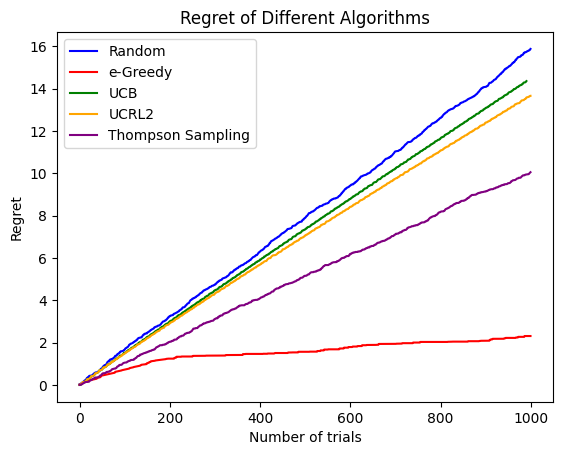

In [7]:
plt.plot(random_regrets, color='blue', label='Random')
plt.plot(eps_regrets, color='red', label='e-Greedy')
plt.plot(ucb_regrets, color='green', label='UCB')
plt.plot(ucbrl2_regrets, color='orange', label='UCRL2')
plt.plot(thompson_regrets, color='purple', label='Thompson Sampling')

# 圖表標題和軸標籤
plt.title('Regret of Different Algorithms')
plt.xlabel('Number of trials')
plt.ylabel('Regret')

# 加入圖例
plt.legend()

# 顯示圖表
plt.show()



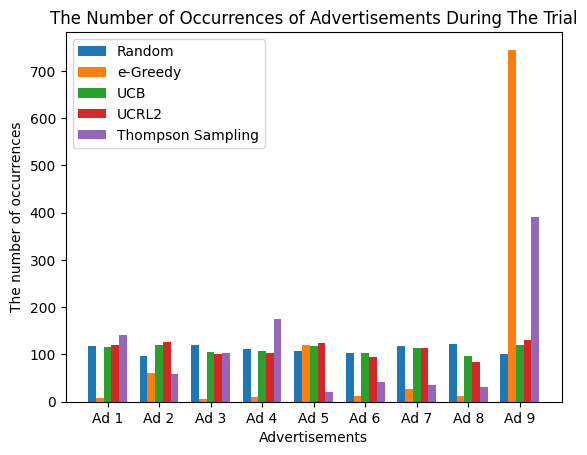

In [8]:
lst = []
lst.append(random_arms)
lst.append(eps_arms)
lst.append(ucb_arms)
lst.append(ucbrl2_arms)
lst.append(thompson_arms)

x_labels = ['Ad 1', 'Ad 2', 'Ad 3', 'Ad 4', 'Ad 5', 'Ad 6', 'Ad 7', 'Ad 8', 'Ad 9']
x = np.arange(len(x_labels))  # X軸的座標位置

# 繪製每個數值序列的柱狀圖
for i, data in enumerate(lst):
    plt.bar(x + i * 0.15, data, width=0.15)

plt.xlabel('Advertisements')
plt.ylabel('The number of occurrences')
plt.title('The Number of Occurrences of Advertisements During The Trial')

# 設定X軸標籤
plt.xticks(x + (len(lst) - 1) * 0.15 / 2, x_labels)

plt.legend(['Random', 'e-Greedy', 'UCB', 'UCRL2', 'Thompson Sampling'])
plt.show()


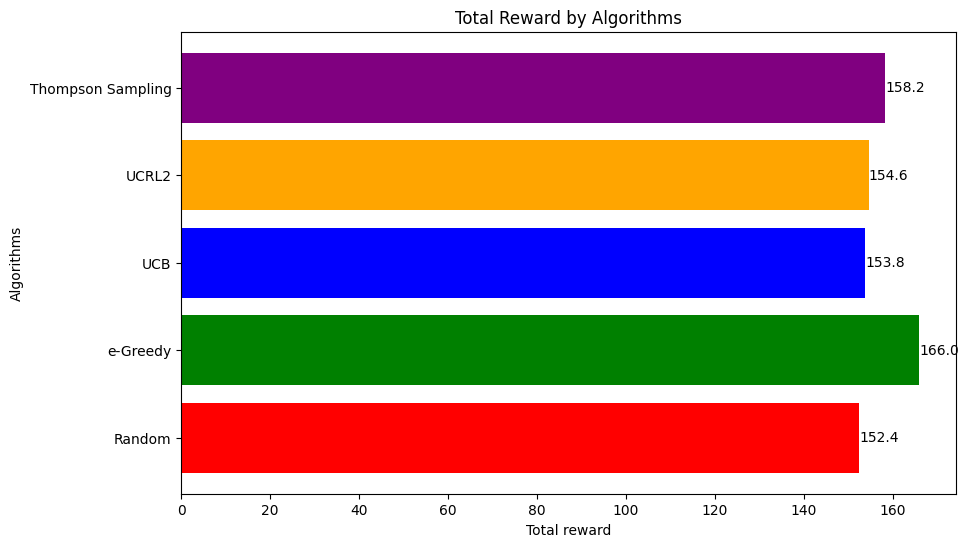

In [9]:
import matplotlib.pyplot as plt

# 定義數據
categories = ['Random', 'e-Greedy', 'UCB', 'UCRL2', 'Thompson Sampling']
values = [np.sum(random_rewards), np.sum(eps_rewards), np.sum(ucb_rewards), np.sum(ucbrl2_rewards), np.sum(thompson_rewards)]

# 定義顏色
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.figure(figsize=(10, 6))

# 繪製橫向柱狀圖並指定顏色
plt.barh(categories, values, color=colors)

# 設置標題和軸標籤
plt.title('Total Reward by Algorithms')
plt.xlabel('Total reward')
plt.ylabel('Algorithms')

# 在每個柱狀圖上標出數字（取到小數點後一位）
for i, value in enumerate(values):
    plt.text(value, i, '{:.1f}'.format(value), ha='left', va='center')

# 顯示圖表
plt.show()
